## NaN handling and some basic statistics about the Dominican Republic weather over the time

### Dictionary 

**Province**: Geographic location of the weather monitoring station.


**weather_station**: place where meteorological data are observed and recorded.


**month**: 1 (meaning January) to 12 (meaning December).


**max_temp (°C)**: highest temperature recorded in a certain date and place. Unit, Celsius degree.


**min_temp (°C)**: lowest temperature recorded in a certain date and place. Unit, Celsius degree.


**wind_velocity (km/h)**: the speed at which the air moves horizontally in a certain date and place. Unit, Kilometers per hour.


**precipitation (mm)**: Identifies the amount of any form of water, in a liquid or solid, falling from the clouds until it reaches the earth. Unit, millimetres.


**relative_humidity (%)**: percentage that measures the amount of water vapor in the air compared to the maximum amount of water vapor the air can hold at a given temperature. Unit, percentage.
re. Unit, percentage.


In this project I am going to manually unpivot the dataset so I can have all the weather measurements recorded in a certain place, year and month, in one single row. Then I will handle the NaN present in the resulting dataframe and finally, I’m going to compute some basic statistics about some weather measurement recorded in the Dominican Republic over the time. The recorded of these measurements go from the year 1960 until 2023. 




**Data Source**: https://www.one.gob.do/datos-y-estadisticas/

In [655]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

In [656]:
#getting the data
data = pd.read_excel(r"C:\Users\DELL\Downloads\atmósfera-y-clima-1960-2023.xlsx")
data.head()

,Provincia,Estación,Año,Mes,Variable,Valor,Unidad de media
0,Samaná,Arroyo Barril,2011,1,Precipitación,29.2,mm
1,Samaná,Arroyo Barril,2011,1,Temperatura máxima,30.0,°C
2,Samaná,Arroyo Barril,2011,1,Temperatura mínima,20.7,°C
3,Samaná,Arroyo Barril,2011,1,Velocidad del viento,10.4,km/h
4,Samaná,Arroyo Barril,2011,1,Nubosidad,4.1,Octas


In [657]:
#taking the data for each individual weather measurement
max_temp_monthly = data[data["Variable"]=="Temperatura máxima"].reset_index(drop=True).drop(columns = ["Variable", "Unidad de media"])
min_temp_monthly = data[data["Variable"]=="Temperatura mínima"].reset_index(drop=True).drop(columns = ["Variable", "Unidad de media"])
precipitation = data[data["Variable"]=="Precipitación"].reset_index(drop=True).drop(columns = ["Variable", "Unidad de media"])
wind_velocity = data[data["Variable"]=="Velocidad del viento"].reset_index(drop=True).drop(columns = ["Variable", "Unidad de media"])
relative_humidity = data[data["Variable"]=="Humedad relativa"].reset_index(drop=True).drop(columns = ["Variable", "Unidad de media"])

In [658]:
#merging max_temp and min_temp datasets in a single dataframe named climate
climate = max_temp_monthly.merge(min_temp_monthly, on = ["Provincia", "Estación", "Año", "Mes"])
climate = climate.rename(columns = {"Valor_x": "max_temp (°C)", "Valor_y": "min_temp (°C)" })
data_frames = [("wind_velocity (km/h)", wind_velocity), 
               ("precipitation (mm)", precipitation), 
               ("relative_humidity (%)", relative_humidity)]

In [659]:
#adding the missing weather measurements to the dataframe climate
#this dataframe will have the specific weather measurements for each tuple (""province",  "weather_station","year","month")
#sNote: ome values might be NaN

for name, df in data_frames:
    climate = climate.merge(df, how="outer", on = ["Provincia",	"Estación",	"Año", "Mes"]).rename(columns ={"Valor":name})


climate = climate.rename(columns = {"Provincia":"province", "Estación": "weather_station","Año":"year","Mes":"month"})


original_data = climate.copy() #Saving a copy of the original dataset in case we need it

climate.head()

,province,weather_station,year,month,max_temp (°C),min_temp (°C),wind_velocity (km/h),precipitation (mm),relative_humidity (%)
0,Barahona,Barahona,2011,1,30.3,19.7,15.6,24.6,72.8
1,Barahona,Barahona,2011,2,31.0,20.1,16.5,6.8,68.1
2,Barahona,Barahona,2011,3,30.5,20.4,17.5,71.6,64.6
3,Barahona,Barahona,2011,4,31.6,22.0,18.2,47.8,66.5
4,Barahona,Barahona,2011,5,31.7,23.0,16.9,58.2,73.1


In [660]:
#taking a look to NaN values per field
climate.isna().sum()

province                   0
weather_station            0
year                       0
month                      0
max_temp (°C)             70
min_temp (°C)             70
wind_velocity (km/h)     479
precipitation (mm)        43
relative_humidity (%)    460
dtype: int64

Since we have a lot of NaN values, we can’t just drop the rows, if we do, we will be lossing a lot of information. In order to reduce the NaN values per field, we will replace the value in a particular field x with the mean of the values of that field group by ("province", "weather_station", "year"). In that way the mean we gonna use to replace the nan, will be representative of the province, weather station and year. Since its computation varies for each ("province", "weather_station", "year").

### NaN handling

In [661]:
#function that replaces the nan values of a given cell by the corresponding mean value
def replace_nanvalue_with_mean(index, province_name, weather_station_name, year_, column):
    if str(climate.at[index, column]) == "nan":
        mask = (climate["province"] == province_name) & (climate["weather_station"] == weather_station_name) & (climate["year"] == year_)
        value = climate[mask][column].mean()
        climate.at[index, column] = value

In [662]:
#let's iterate by row and replace the nan value that we find
for row in climate[climate.isna().any(axis=1)].iterrows():
    replace_nanvalue_with_mean(row[0], row[1]["province"], row[1]["weather_station"], row[1]["year"], "min_temp (°C)")
    replace_nanvalue_with_mean(row[0], row[1]["province"], row[1]["weather_station"], row[1]["year"], "max_temp (°C)")
    replace_nanvalue_with_mean(row[0], row[1]["province"], row[1]["weather_station"], row[1]["year"], "wind_velocity (km/h)")
    replace_nanvalue_with_mean(row[0], row[1]["province"], row[1]["weather_station"], row[1]["year"], "precipitation (mm)")
    replace_nanvalue_with_mean(row[0], row[1]["province"], row[1]["weather_station"], row[1]["year"], "relative_humidity (%)")
    

In [663]:
#once again let's take a look to NaN values per field
climate.isna().sum()

province                   0
weather_station            0
year                       0
month                      0
max_temp (°C)             24
min_temp (°C)             24
wind_velocity (km/h)     394
precipitation (mm)        12
relative_humidity (%)    358
dtype: int64

We still got quite a few NaN values per field. But given the replacement we just made, the only way for a cell to be NaN is that all the values for in a given field for a particular ("province", "weather_station", "year") are NaN. Let’s look into that:

In [664]:
temperature = climate[["province", "weather_station","year","month", "min_temp (°C)", "max_temp (°C)"]]
temperature[temperature.isna().any(axis=1)]

,province,weather_station,year,month,min_temp (°C),max_temp (°C)
1487,San Cristóbal,Villa Altagracia,2011,1,NaN,NaN
1488,San Cristóbal,Villa Altagracia,2011,2,NaN,NaN
1489,San Cristóbal,Villa Altagracia,2011,3,NaN,NaN
1490,San Cristóbal,Villa Altagracia,2011,4,NaN,NaN
1491,San Cristóbal,Villa Altagracia,2011,5,NaN,NaN
1492,San Cristóbal,Villa Altagracia,2011,6,NaN,NaN
1493,San Cristóbal,Villa Altagracia,2011,7,NaN,NaN
1494,San Cristóbal,Villa Altagracia,2011,8,NaN,NaN
1495,San Cristóbal,Villa Altagracia,2011,9,NaN,NaN
1496,San Cristóbal,Villa Altagracia,2011,10,NaN,NaN


In [665]:
precipitation = climate[["province", "weather_station","year","month", "precipitation (mm)"]]
precipitation[precipitation.isna().any(axis=1)]

,province,weather_station,year,month,precipitation (mm)
2230,Santo Domingo,Las Américas,1981,1,NaN
2231,Santo Domingo,Las Américas,1981,2,NaN
2232,Santo Domingo,Las Américas,1981,3,NaN
2233,Santo Domingo,Las Américas,1981,4,NaN
2234,Santo Domingo,Las Américas,1981,5,NaN
2235,Santo Domingo,Las Américas,1981,6,NaN
2236,Santo Domingo,Las Américas,1981,7,NaN
2237,Santo Domingo,Las Américas,1981,8,NaN
2238,Santo Domingo,Las Américas,1981,9,NaN
2239,Santo Domingo,Las Américas,1981,10,NaN


So far it is as expected, if a cell is NaN, then all the values in that field for the corresponding ("province", "weather_station", "year") are NaN. In these two cases:

 We don’t have temperatures values for the in the province “San Cristóba”, station “Villa Altagracia” in the years 2011 and 2012.

And we don’t have precipitation values for Santo Domingo, station Las Américas in the year 1981.

Let's take a look of the others fields.


In [666]:
wind_velocity = climate[["province", "weather_station","year","month", "wind_velocity (km/h)"]]
wind_velocity[wind_velocity.isna().any(axis=1)]

,province,weather_station,year,month,wind_velocity (km/h)
156,Barahona,Polo,2011,1,NaN
157,Barahona,Polo,2011,2,NaN
158,Barahona,Polo,2011,3,NaN
159,Barahona,Polo,2011,4,NaN
160,Barahona,Polo,2011,5,NaN
...,...,...,...,...,...
2333,Santo Domingo,Las Américas,1989,8,NaN
2334,Santo Domingo,Las Américas,1989,9,NaN
2335,Santo Domingo,Las Américas,1989,10,NaN
2336,Santo Domingo,Las Américas,1989,11,NaN


In [667]:
relative_humidity = climate[["province", "weather_station","year","month", "relative_humidity (%)"]]
relative_humidity[relative_humidity.isna().any(axis=1)]

,province,weather_station,year,month,relative_humidity (%)
156,Barahona,Polo,2011,1,NaN
157,Barahona,Polo,2011,2,NaN
158,Barahona,Polo,2011,3,NaN
159,Barahona,Polo,2011,4,NaN
160,Barahona,Polo,2011,5,NaN
...,...,...,...,...,...
2333,Santo Domingo,Las Américas,1989,8,NaN
2334,Santo Domingo,Las Américas,1989,9,NaN
2335,Santo Domingo,Las Américas,1989,10,NaN
2336,Santo Domingo,Las Américas,1989,11,NaN


We gonna replace these NaN values as follows:

For temperature, the 2011 and 2012 NaN we gonna replace them with the 2013 and 2014 values respectively each month. In both cases we’ll take the values from the same province and weather station.

For precipitation, the NaN will be replaced with the values of the year 1982. Once again, we’ll take the values from the same province and weather station.

For wind velocity and relative humidity, we will just replace the NaN with the country average value per month. Meaning that in this case we will not consider the province nor the weather station. 




In [668]:
def replace_temperature_nan():
    '''
    Replace the NaN values in the "max_temp (°C)" and "min_temp (°C)" fields with the values of the years 2013 and 2014 for each month.
    It takes the values from the same province and weather station.
    
    '''
    mask = ((climate["province"] == "San Cristóbal") & (climate["weather_station"] == "Villa Altagracia")) & \
           ((climate["year"] == 2013) | (climate["year"] == 2014))
    replacement_list = []
    for row1, row2 in zip(climate[climate[["max_temp (°C)"]].isna().any(axis=1)].iterrows(), climate[mask].iterrows()):
        element = (row1[0], row2[1]["min_temp (°C)"], row2[1]["max_temp (°C)"])
        replacement_list.append(element)
        
    
    for replacement in replacement_list:
        index, min_temp, max_temp = replacement
        climate.at[index, "min_temp (°C)"] = min_temp
        climate.at[index, "max_temp (°C)"] = max_temp

In [669]:
def replace_precipitation_nan():
    '''
    Replace the NaN values in the "precipitation (mm)" field with the values of the year 1982 for each month.
    It takes the values from the same province and weather station.
    
    '''
    
    mask = ((climate["province"] == "Santo Domingo") & (climate["weather_station"] == "Las Américas")) & (climate["year"] == 1982)
    replacement_list = []
    
    for row1, row2 in zip(climate[climate[["precipitation (mm)"]].isna().any(axis=1)].iterrows(), precipitation[mask].iterrows()):
        element = (row1[0], row2[1]["precipitation (mm)"])
        replacement_list.append(element)
        
    
    for replacement in replacement_list:
        index, precip_value = replacement
        climate.at[index, "precipitation (mm)"] = precip_value 

In [670]:
def replace_wind_humidity_nan():
    '''
    Replace the NaN values in the "wind_velocity (km/h)" and "relative_humidity (%)" fields 
    with the country average value per month for each field.
    
    '''
    for field in ["wind_velocity (km/h)", "relative_humidity (%)"]:
        replacement_list = []
        replacement_df = climate.groupby("month").agg({field:"mean"})
        for row in climate[climate[[field]].isna().any(axis=1)].iterrows():
            element = (row[0],  replacement_df.loc[row[1]["month"], field] )
            replacement_list.append(element)
    
        for replacement in replacement_list:
            index, value = replacement
            climate.at[index, field] = value  

In [671]:
#Execute the NaN replacement functions
replace_temperature_nan()
replace_precipitation_nan()
replace_wind_humidity_nan()

In [672]:
#once again let's take a look to NaN values per field
climate.isna().sum()

province                 0
weather_station          0
year                     0
month                    0
max_temp (°C)            0
min_temp (°C)            0
wind_velocity (km/h)     0
precipitation (mm)       0
relative_humidity (%)    0
dtype: int64

Now let’s get some basic statistics about the dataset.

### Statistics

In [673]:
#Getting the average of the measurement  per year 
measument_mean_over_the_years = climate.groupby(by=["year"]).agg({"min_temp (°C)": "mean", "max_temp (°C)": "mean", 
                                  "wind_velocity (km/h)": "mean", "relative_humidity (%)": "mean",})

#For precipitation it works a bit differently. We first have to sum up the monthly precipitation per year and province, 
#this will get us the precipitation of the country per year that each province measured. Then we take the average per year of that result. 
precipitation_over_the_years_province = climate.groupby(by=["year", "province"]).agg({ "precipitation (mm)": "sum"} )
precipitation_mean_over_the_years = precipitation_over_the_years_province.reset_index().groupby(by=["year"]).agg({"precipitation (mm)": "mean"} )

measument_mean_over_the_years

,min_temp (°C),max_temp (°C),wind_velocity (km/h),relative_humidity (%)
year,,,,
1960,21.308333,30.516667,11.227895,79.235049
1961,20.675000,30.633333,11.400000,84.127273
1962,20.691667,30.716667,7.633333,83.718182
1963,21.141667,30.675000,12.450000,83.250000
1964,20.925000,30.641667,14.291667,83.875000
...,...,...,...,...
2019,21.854444,31.389444,10.971919,78.033781
2020,22.585955,31.752247,10.710112,78.702921
2021,22.074607,31.611137,10.566092,78.653426


We can see an increase in the min and max temperature over the years. And a decrease in relative humidity. While wind velocity seams to be moving in a closed range, there may be some outliers in a particular year. Let’s see this graphically. 

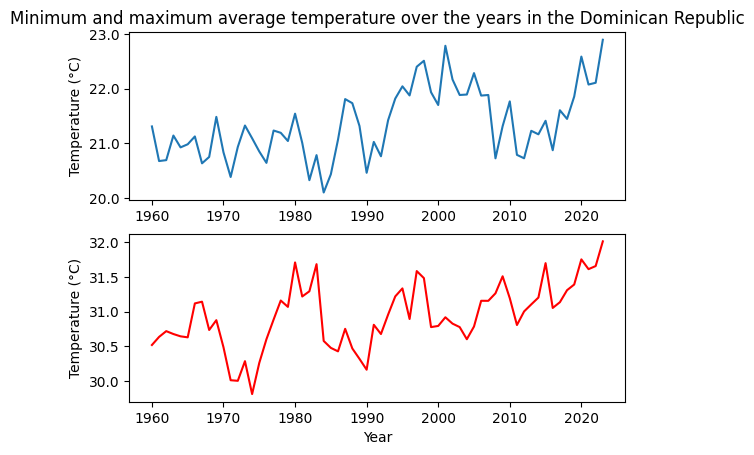

In [674]:
#temperatures
ax = plt.subplot(2,1,1)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.plot(measument_mean_over_the_years.index, measument_mean_over_the_years["min_temp (°C)"])
plt.ylabel("Temperature (°C)")
plt.title("Minimum and maximum average temperature over the years in the Dominican Republic")
plt.subplot(2,1,2)
plt.plot(measument_mean_over_the_years.index, measument_mean_over_the_years["max_temp (°C)"], c="red")
plt.xlabel("Year")
plt.ylabel("Temperature (°C)");


The temperature has been increasing over the years. Having its peak in 2023.

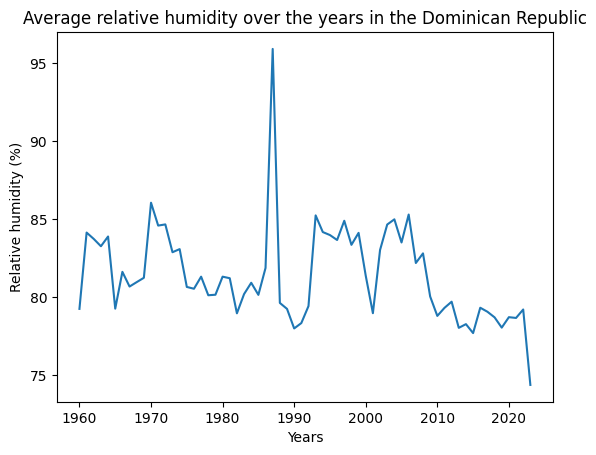

In [675]:
plt.plot(measument_mean_over_the_years.index, measument_mean_over_the_years["relative_humidity (%)"])
plt.ylabel("Relative humidity (%)")
plt.xlabel("Years")
plt.title("Average relative humidity over the years in the Dominican Republic");

Overall, the average relative humidity has been decreasing over the years. But there is an outlier in the year 1987.

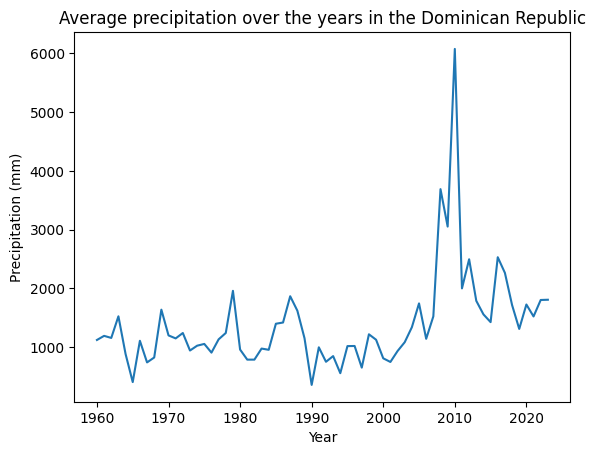

In [676]:
plt.plot(precipitation_mean_over_the_years.index, precipitation_mean_over_the_years["precipitation (mm)"])
plt.ylabel("Precipitation (mm)")
plt.xlabel("Year")
plt.title("Average precipitation over the years in the Dominican Republic");

The precipitation per year had been lower than 2000 mm, but in 2008, 2009 and 2010 it went over 3000 mm with its highest of 6076 mm in 2010.

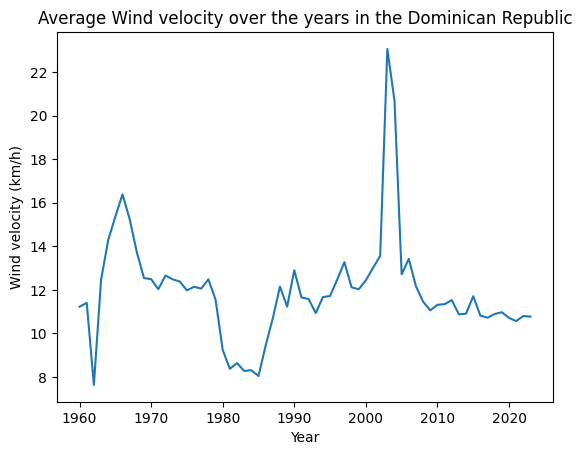

In [677]:
plt.plot(measument_mean_over_the_years.index, measument_mean_over_the_years["wind_velocity (km/h)"])
plt.ylabel("Wind velocity (km/h)")
plt.xlabel("Year")
plt.title("Average Wind velocity over the years in the Dominican Republic");

The average wind velocity is stable. But has two big outliers in 2003 and 2004, since on average the wind velocity is between 12 – 15 km/h and in 2003 and 2004 was 23 km/h and 20 km/h respectively.

#### Some statistics per month

In [678]:
measument_mean_per_month = climate.groupby(by=["month"]).agg({"min_temp (°C)": "mean", "max_temp (°C)": "mean", 
                                  "wind_velocity (km/h)": "mean", "relative_humidity (%)": "mean", "precipitation (mm)": "mean"})

measument_mean_per_month

,min_temp (°C),max_temp (°C),wind_velocity (km/h),relative_humidity (%),precipitation (mm)
month,,,,,
1,19.424614,29.652509,10.605190,80.108026,72.298109
2,19.645346,29.918229,11.687398,78.380178,67.959044
3,19.868727,30.198124,11.964287,76.854864,75.184810
4,21.057476,30.899256,11.912025,77.221372,104.464728
5,22.192645,31.389639,11.669679,78.945644,151.256681
6,23.034130,32.255877,11.987847,78.129713,101.620874
7,23.169100,32.570753,12.783122,78.160477,140.378978
8,23.211543,32.613839,11.741474,79.565596,177.244681
9,22.957020,32.642301,10.921032,80.176089,152.411755


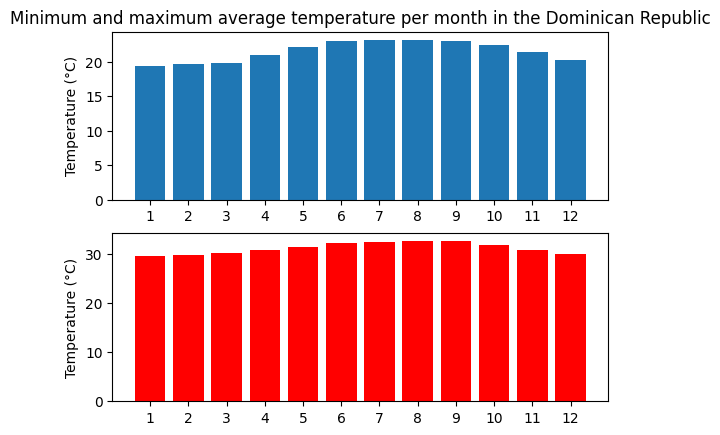

In [679]:
plt.subplot(2,1,1)
plt.bar(measument_mean_per_month.index, measument_mean_per_month["min_temp (°C)"])
plt.ylabel("Temperature (°C)")
plt.xticks(measument_mean_per_month.index) 
plt.title("Minimum and maximum average temperature per month in the Dominican Republic")
plt.subplot(2,1,2)
plt.bar(measument_mean_per_month.index, measument_mean_per_month["max_temp (°C)"], color="red")
plt.xticks(measument_mean_per_month.index) 
plt.ylabel("Temperature (°C)"); 

These two charts show that temperature in Dominican Republic has its low peaks in December, January and February, being the lowest in January. In the other hand, it has its high peaks in July, August and September, being the highest in August and September.

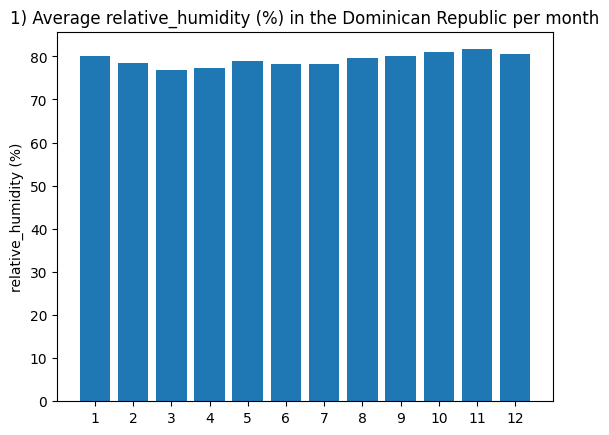

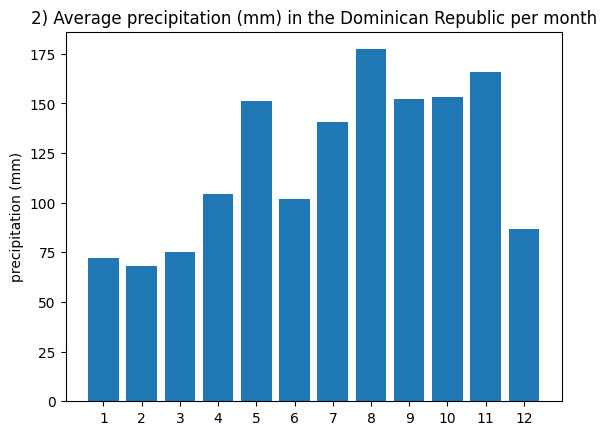

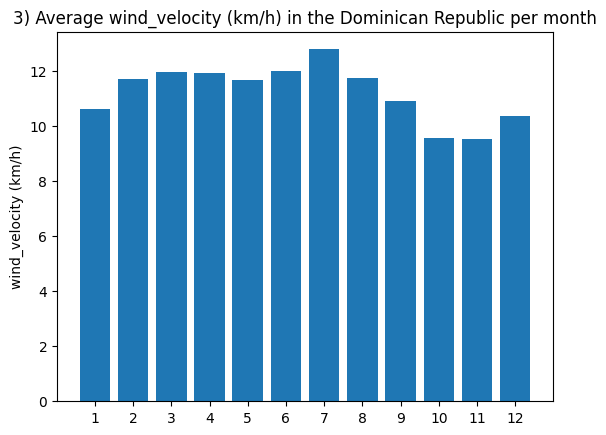

In [680]:
i=1
for field in ["relative_humidity (%)", "precipitation (mm)",  "wind_velocity (km/h)"]:
    plt.bar(measument_mean_per_month.index, measument_mean_per_month[field])
    plt.xticks(measument_mean_per_month.index) 
    plt.title(f"{i}) Average {field} in the Dominican Republic per month")
    plt.xticks(measument_mean_per_month.index) 
    plt.ylabel(field)
    i+=1
    plt.show(); 

**Chart 1**: The values over the months are uniform.



**Chart 2**: This chart shows that in average May, August, September, October and November are the months with the highest precipitation, being August the highest. In the other hand, January, February and March are the months with the lowest precipitation.


**Chart 3**: The average wind velocity is the lowest in October and November. And it is the highest in July.

##### Let’s now look for the month where we have registered the maximum and minimum temperature and the highest precipitation. 

In [681]:
measument_min_max_per_month = climate.groupby(by=["month"]).agg({"min_temp (°C)": "min", "max_temp (°C)": "max", 
                                                                "precipitation (mm)": "max"})

measument_min_max_per_month

,min_temp (°C),max_temp (°C),precipitation (mm)
month,,,
1,12.9,33.400000,608.8
2,13.2,33.800000,423.3
3,0.0,34.241935,604.9
4,14.8,39.700000,547.1
5,14.2,35.700000,605.5
6,15.9,37.000000,916.0
7,17.8,37.100000,738.3
8,18.0,36.900000,767.0
9,17.2,37.300000,650.9


As we can see we have the maximum historical temperature was measured in April, the highest precipitation values was registered in November.


For the minimum temperature we have an odd result since we have 0 on march, and all the other months are over 12. For now, let’s just say that the lowest temperature was registered in in November, but we should look into that.


Now let’s take a look on those number in the original dataset. 


In [682]:
#max temperature
original_data[original_data["max_temp (°C)"]>36.8]

,province,weather_station,year,month,max_temp (°C),min_temp (°C),wind_velocity (km/h),precipitation (mm),relative_humidity (%)
420,Independencia,Jimaní,2020,6,37.0,26.1,12.8,20.2,74.4
421,Independencia,Jimaní,2020,7,37.0,26.1,12.3,73.3,67.2
933,Monte Cristi,Monte Cristi,2023,7,37.1,25.4,13.2,36.1,66.3
934,Monte Cristi,Monte Cristi,2023,8,36.9,24.9,12.9,56.1,66.8
935,Monte Cristi,Monte Cristi,2023,9,37.3,25.4,11.8,9.8,68.0
1814,Santo Domingo,Higüero,2009,4,39.7,21.1,NaN,71.1,NaN


Even though the maximum temperature was registered in 2009, evidence shows that in the future (2020, 2021, 2022, 2023) we had higher peaks constantly every year.

In [683]:
#highest precipitation
original_data[original_data["precipitation (mm)"]>1000]

,province,weather_station,year,month,max_temp (°C),min_temp (°C),wind_velocity (km/h),precipitation (mm),relative_humidity (%)
1248,Puerto Plata,La Unión,2016,11,29.0,21.9,7.9,1060.0,90.7


The highest precipitation was registered in November 2016.

In [649]:

original_data[original_data["min_temp (°C)"]<12.4]

,province,weather_station,year,month,max_temp (°C),min_temp (°C),wind_velocity (km/h),precipitation (mm),relative_humidity (%)
216,Barahona,Polo,2016,3,26.5,0.0,NaN,103.7,NaN
1437,Samaná,Catey,2019,11,30.9,12.3,8.7,178.0,85.0


As we can see nothing lower than 12.3 has ever been registered in the min_temp field but that single case. We will take November as the month with lowest temperature ever recorded, but we should still investigate the data source to know if that value makes sense or if it is a mistake.

### Conclusion 

Further work, get some more advanced statistics, make a regression model that predicts the maximum temperature for the next year, make a classification model that predicts if the maximum temperature of the next year is going to be over 36 °C or not. 


Note: I am not a climatologist nor a meteorologist, so some of the calculations might not make sense from an expert point of view, I apologize for that. But I am just trying to make sense out of the numbers because this is a very interesting subject. With that been said, I would appreciate any advice. 
